In [3]:
import pandas as pd
from datetime import datetime

header = ['GPST', 'lat_deg', 'long_deg', 'height_m', 'Q', 'ns', 'sdn_m', 'sde_m', 'sdu_m', 'sdne_m', 'sdeu_m', 'sdun_m', 'age_s', 'ratio']
custom_date_parser = lambda x: datetime.strptime(x, "%Y/%m/%d %H:%M:%S.%f")
df = pd.read_csv('ublox_complete.pos', delimiter=r"\s\s+", comment='%', header=None, names=header, parse_dates=['GPST'], date_parser=custom_date_parser, engine = 'python')
df['GPST Seconds'] = df['GPST'].astype('int64')//1e9


In [4]:
import utm
# lon -> x, lat -> y

zoned = pd.DataFrame(list(df.apply(lambda row: utm.from_latlon(row['lat_deg'], row['long_deg']), axis=1)), columns=['x', 'y', 'zone id', 'zone grid'])

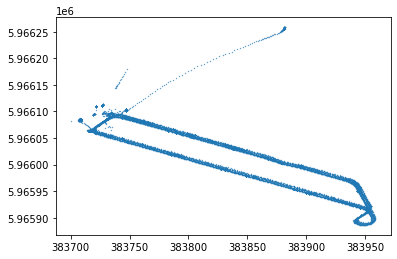

In [5]:
import matplotlib.pyplot as plt

plt.scatter(zoned['x'], zoned['y'], s=0.1)

Idea: i want to detect the lanes using movement: similar movement == parallel movement == movement in lanes

In [6]:
import numpy as np
age = np.ediff1d(df['GPST Seconds'])

x_movements = np.ediff1d(zoned['x'])/age
y_movements = np.ediff1d(zoned['y'])/age
x_movements = np.where(x_movements < 0, -x_movements, x_movements)
y_movements = np.where(y_movements < 0 ,-y_movements, y_movements)

(-0.1, 4.0)

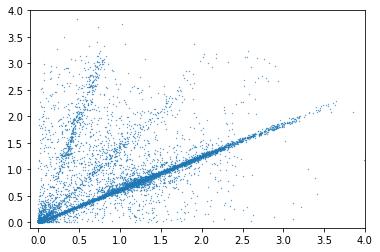

In [7]:
plt.scatter(x_movements, y_movements, s = 0.1)
plt.xlim([-0.1, 4])
plt.ylim([-0.1, 4])

I want to find the 3 "axis" of movements here. the main axis of movement should be the movement inside lanes.

Use colar coordinates to find degree, then cluster similar degrees together

In [8]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

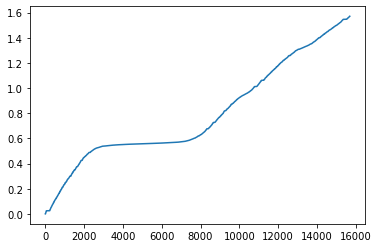

In [9]:
_, deg = cart2pol(x_movements, y_movements)
deg.sort()
plt.plot(deg)

The big plateau here should be the main axis of movement. The gradient should me small in this region

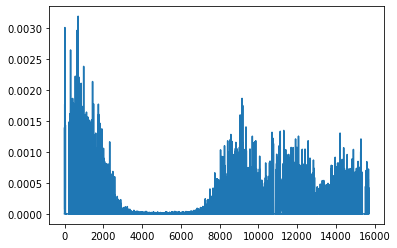

In [10]:
gradient = np.ediff1d(deg)
plt.plot(gradient)

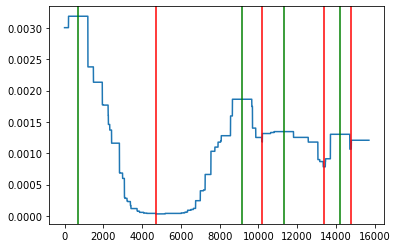

In [16]:
from scipy.ndimage import maximum_filter, median_filter
from scipy.signal import find_peaks

smoothed_gradient = maximum_filter(gradient, 1000)
min_peaks, _ = find_peaks(-smoothed_gradient)
max_peaks, _ = find_peaks(smoothed_gradient)

plt.plot(smoothed_gradient)
for min_peak in min_peaks:
    plt.axvline(min_peak, color='r')
for max_peak in max_peaks:
    plt.axvline(max_peak, color='g')

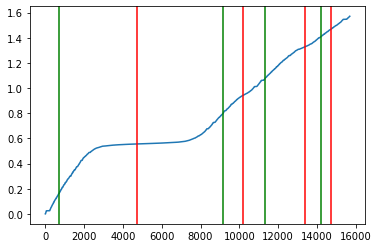

In [17]:
plt.plot(deg)
for min_peak in min_peaks:
    plt.axvline(min_peak, color='r')
for max_peak in max_peaks:
    plt.axvline(max_peak, color='g')